![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

## Datos para la predicción de género en películas

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

## Ejemplo predicción conjunto de test para envío a Kaggle
En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
# Ignorar alertas
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Uso de GPU (Local)
import torch                                                                   # Librería principal de PyTorch
from torch import cuda                                                         # Librería para trabajar con GPU
USE_GPU = torch.cuda.is_available()                                            # Activar uso de GPU
device = torch.device('cuda' if USE_GPU else 'cpu')                            # Dispositivo (GPU o CPU)
print("GPU de uso: ", torch.cuda.get_device_name())

# Importación librerías
import os                                                                      # Librería para interactuar con el sistema operativo
import pandas as pd                                                            # Librería para manipulación de datos
import matplotlib.pyplot as plt                                                # Librería para visualización de datos
import seaborn as sns                                                          # Librería para visualización de datos
import numpy as np                                                             # Librería para manipulación de arrays y matrices

from sklearn.model_selection import train_test_split                           # División de datos en entrenamiento y prueba
from sklearn.feature_extraction.text import CountVectorizer                    # Vectorización de texto
from sklearn.preprocessing import MultiLabelBinarizer                          # Binarización de etiquetas múltiples
from sklearn.multiclass import OneVsRestClassifier                             # Vectorización de etiquetas múltiples
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier     # Modelos de bosque aleatorio
from sklearn.linear_model import LogisticRegression                            # Regresión logística
from sklearn.metrics import r2_score, roc_auc_score                            # Métricas de evaluación

import torch.nn as nn                                                          # Redes neuronales
import torch.optim as optim                                                    # Optimizadores de PyTorch
from torch.utils.data import DataLoader, TensorDataset                         # Cargador de datos de PyTorch

GPU de uso:  NVIDIA GeForce RTX 3090 Ti


In [3]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [4]:
# Verifica que son listas
print(type(dataTraining['genres'].iloc[0]))  # Debe decir: <class 'str'> o <class 'list'>

# Si los géneros están como strings, convertirlos a listas
if isinstance(dataTraining['genres'].iloc[0], str):
    dataTraining['genres'] = dataTraining['genres'].apply(eval)

<class 'str'>


In [5]:
# Binarizar
mlb = MultiLabelBinarizer()
y_genres = mlb.fit_transform(dataTraining['genres'])

In [6]:
# Bert Embeddings
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
tqdm.pandas()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

# Embedings para los datos de entrenamiento y prueba
dataTraining['plot_clean_bert'] = dataTraining['plot'].progress_apply(get_bert_embeddings)
dataTesting['plot_clean_bert'] = dataTesting['plot'].progress_apply(get_bert_embeddings)

# Ejecución del modelo
X = np.vstack(dataTraining['plot_clean_bert'].values)
y = y_genres

# Rest of your model code...
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

100%|██████████| 3383/3383 [00:17<00:00, 196.53it/s]


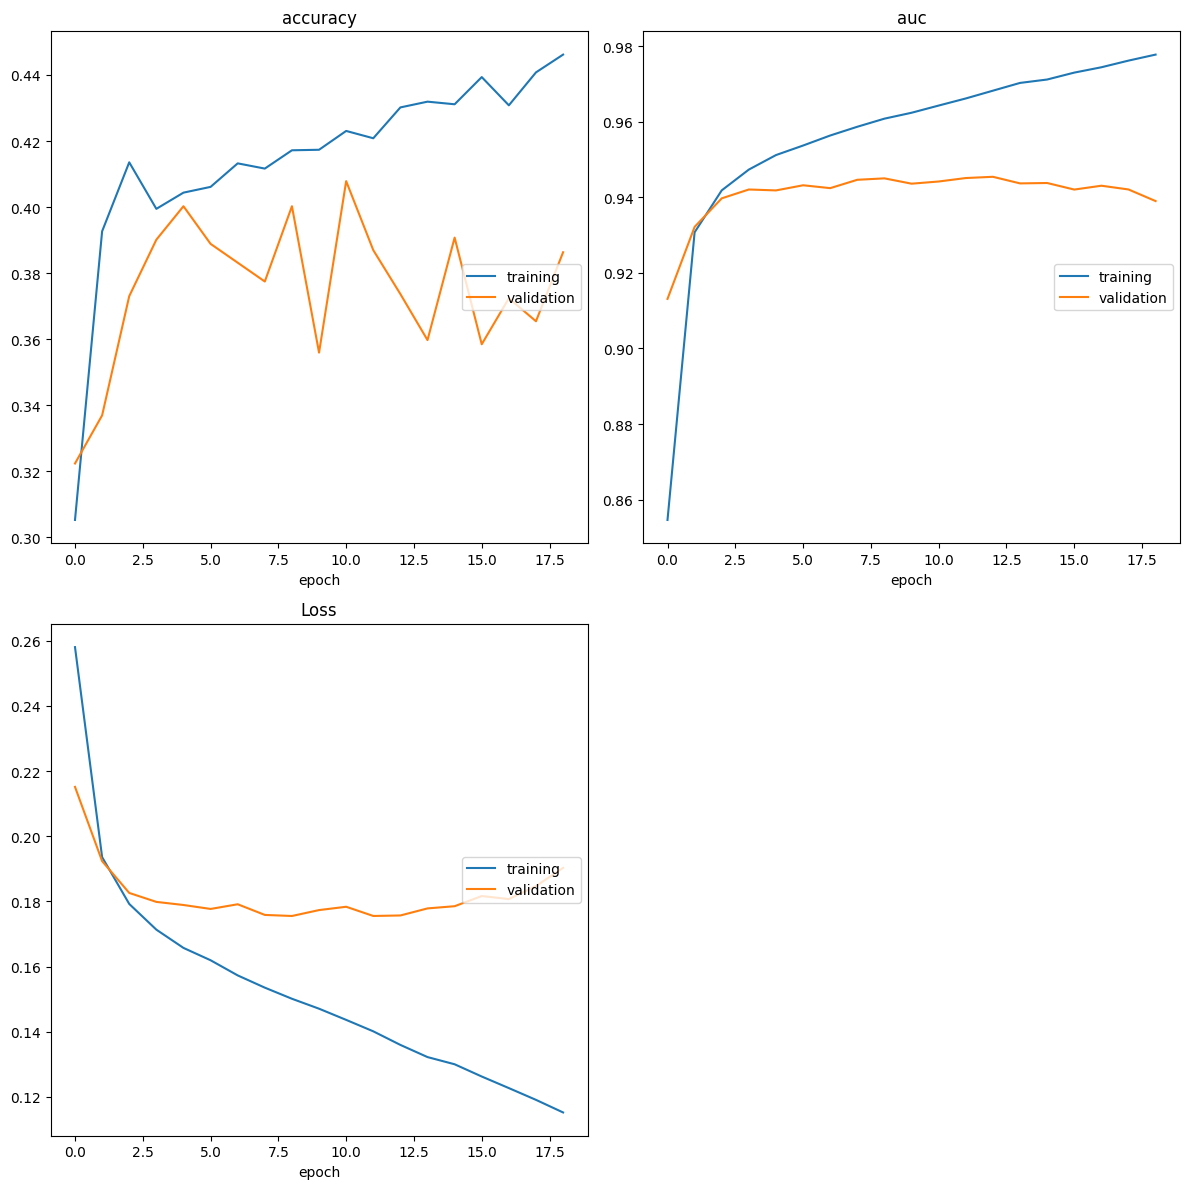

accuracy
	training         	 (min:    0.305, max:    0.446, cur:    0.446)
	validation       	 (min:    0.322, max:    0.408, cur:    0.386)
auc
	training         	 (min:    0.855, max:    0.978, cur:    0.978)
	validation       	 (min:    0.913, max:    0.945, cur:    0.939)
Loss
	training         	 (min:    0.115, max:    0.258, cur:    0.115)
	validation       	 (min:    0.176, max:    0.215, cur:    0.190)
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4424 - auc: 0.9782 - loss: 0.1140 - val_accuracy: 0.3863 - val_auc: 0.9390 - val_loss: 0.1903

Evaluación en conjunto de validación:
Loss: 0.1755, Accuracy: 0.4003, AUC: 0.9450
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
Modelo guardado como modelo_nn.keras


In [8]:
# Definición de dimensiones de salida (variables de interés)
output_var = y_train.shape[1]
print(output_var, 'output variables')

# Definición de dimensiones de entrada (variables predictoras)
dims = X_train.shape[1]
print(dims, 'input variables')

# Importación librerías
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend as K
from livelossplot import PlotLossesKeras
import tensorflow as tf

# Configuración de GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU disponible y configurada")
else:
    print("No se encontró GPU, usando CPU")

# Definición de función que crea la red neuronal
def nn_model_params(optimizer='adam',
                   neurons=512,
                   batch_size=32,
                   epochs=150,
                   activation='relu',
                   patience=5,
                   loss='binary_crossentropy'):
    
    K.clear_session()

    model = Sequential()
    
    # Capa de entrada y primera capa oculta
    model.add(Dense(neurons, input_shape=(dims,), activation=activation))
    # Segunda capa oculta
    model.add(Dense(neurons, activation=activation))
    # Capa de salida (usamos sigmoid para clasificación multi-etiqueta)
    model.add(Dense(output_var, activation='sigmoid'))

    # Compilación del modelo
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy', metrics.AUC(name='auc')])
    
    # Early Stopping
    early_stopping = EarlyStopping(monitor="val_loss",
                                 patience=patience,
                                 restore_best_weights=True)

    # Entrenamiento del modelo
    history = model.fit(X_train, y_train,
                       validation_data=(X_val, y_val),
                       epochs=epochs,
                       batch_size=batch_size,
                       callbacks=[early_stopping, PlotLossesKeras()],
                       verbose=1)
    
    return model, history

# Parámetros mejorados
params = {
    'optimizer': 'adamw',
    'neurons': 384,
    'batch_size': 64,
    'epochs': 150,
    'activation': 'relu',
    'patience': 10,
    'loss': 'binary_crossentropy'
}

# Entrenamiento del modelo
model, history = nn_model_params(**params)

# Evaluación del modelo
print("\nEvaluación en conjunto de validación:")
val_loss, val_acc, val_auc = model.evaluate(X_val, y_val, verbose=0)
print(f"Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}")

# Predicción en el conjunto de prueba
y_pred_test = model.predict(np.vstack(dataTesting['plot_clean_bert'].values))

# Guardar el modelo
model.save('modelo_nn.keras')
print("Modelo guardado como modelo_nn.keras")

In [9]:
roc_auc_test = roc_auc_score(y_genres, model.predict(X), average='macro')
roc_auc_test

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step


np.float64(0.9488482545217201)

## Aplicación del modelo a datos de test

In [9]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

In [10]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_NN.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.001559,0.010248,0.000204,0.002992,0.010389,0.010144,0.000209,0.872927,0.002053,0.035695,...,0.000233,0.297059,0.000050,0.480837,0.006634,0.001427,0.000018,0.338069,0.000607,0.005996
4,0.063520,0.033687,0.000125,0.298134,0.153175,0.217476,0.220015,0.785417,0.001631,0.000273,...,0.000366,0.007681,0.004641,0.044328,0.000112,0.000231,0.002907,0.141293,0.002294,0.000022
5,0.018393,0.004921,0.000041,0.051250,0.010937,0.650827,0.010410,0.815193,0.000428,0.002438,...,0.000049,0.633319,0.001489,0.034007,0.004091,0.000092,0.000212,0.840308,0.000859,0.000443
6,0.205798,0.162542,0.000542,0.008018,0.145933,0.025450,0.000287,0.663095,0.003706,0.007985,...,0.003199,0.069931,0.000067,0.222773,0.061346,0.000375,0.001017,0.501991,0.350432,0.002194
7,0.003051,0.001326,0.000723,0.002107,0.047554,0.014571,0.000276,0.179616,0.004541,0.073436,...,0.001664,0.112073,0.000008,0.053841,0.732020,0.005109,0.000012,0.301893,0.000025,0.000083


## Modelo Randomized Search, optimiza Hiperparámetros

In [10]:
import numpy as np
from sklearn.metrics import roc_auc_score
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Definir espacio de parámetros
param_dist = {
    'units1': [256, 384, 512, 768, 1024],
    'units2': [256, 384, 512, 768, 1024],
    'learning_rate': [0.01, 0.001, 0.0001],
    'activation': ['relu', 'tanh', 'elu'],
    'batch_size': [16, 32, 64]
}

# Número de combinaciones a probar
n_iter_search = 50
best_auc = 0
best_params = {}

for i in range(n_iter_search):
    print(f"\nPrueba {i+1}/{n_iter_search}")
    
    # Seleccionar parámetros aleatorios
    params = {k: np.random.choice(v) for k, v in param_dist.items()}
    print("Parámetros:", params)
    
    # Construir modelo
    model = Sequential()
    model.add(Dense(params['units1'], input_shape=(dims,), activation=params['activation']))
    model.add(Dense(params['units2'], activation=params['activation']))
    model.add(Dense(output_var, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    
    # Entrenamiento con early stopping
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=params['batch_size'],
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1)]
    )
    
    # Evaluar modelo
    val_loss, val_acc, val_auc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Resultado - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}")
    
    # Actualizar mejores parámetros
    if val_auc > best_auc:
        best_auc = val_auc
        best_params = params
        best_model = model
        print("¡Nuevo mejor modelo encontrado!")

# Resultados finales
print("\nMejores parámetros encontrados:")
for k, v in best_params.items():
    print(f"{k}: {v}")
print(f"Mejor AUC de validación: {best_auc:.4f}")

# Entrenar el mejor modelo con más épocas
final_model = best_model
history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=best_params['batch_size'],
    callbacks=[EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
)

# Guardar el mejor modelo
final_model.save('best_nn_model_manual.keras')
print("Mejor modelo guardado como 'best_nn_model_manual.keras'")


Prueba 1/50
Parámetros: {'units1': np.int64(384), 'units2': np.int64(384), 'learning_rate': np.float64(0.0001), 'activation': np.str_('relu'), 'batch_size': np.int64(64)}
Epoch 34: early stopping
Resultado - Loss: 0.1736, Accuracy: 0.3990, AUC: 0.9462
¡Nuevo mejor modelo encontrado!

Prueba 2/50
Parámetros: {'units1': np.int64(768), 'units2': np.int64(384), 'learning_rate': np.float64(0.0001), 'activation': np.str_('elu'), 'batch_size': np.int64(64)}
Epoch 21: early stopping
Resultado - Loss: 0.1777, Accuracy: 0.3730, AUC: 0.9436

Prueba 3/50
Parámetros: {'units1': np.int64(256), 'units2': np.int64(1024), 'learning_rate': np.float64(0.0001), 'activation': np.str_('elu'), 'batch_size': np.int64(16)}
Epoch 18: early stopping
Resultado - Loss: 0.1797, Accuracy: 0.3914, AUC: 0.9425

Prueba 4/50
Parámetros: {'units1': np.int64(512), 'units2': np.int64(1024), 'learning_rate': np.float64(0.0001), 'activation': np.str_('elu'), 'batch_size': np.int64(32)}
Epoch 16: early stopping
Resultado - L

Epoch 1/200
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1622 - auc: 0.6635 - loss: 0.4970 - val_accuracy: 0.4015 - val_auc: 0.9005 - val_loss: 0.2286 - learning_rate: 1.0000e-04
Epoch 2/200
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3654 - auc: 0.8936 - loss: 0.2259 - val_accuracy: 0.3616 - val_auc: 0.9239 - val_loss: 0.2017 - learning_rate: 1.0000e-04
Epoch 3/200
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3811 - auc: 0.9212 - loss: 0.2013 - val_accuracy: 0.4009 - val_auc: 0.9316 - val_loss: 0.1934 - learning_rate: 1.0000e-04
Epoch 4/200
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3966 - auc: 0.9326 - loss: 0.1881 - val_accuracy: 0.4066 - val_auc: 0.9354 - val_loss: 0.1890 - learning_rate: 1.0000e-04
Epoch 5/200
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3972 - auc: 0.9394 - loss: 0.1809 - val_accuracy: 0.3933 - val_auc: 0.9362 - val_loss: 0.1873 - learning_rate: 1.0000e-04
Epoch 6/200
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - 

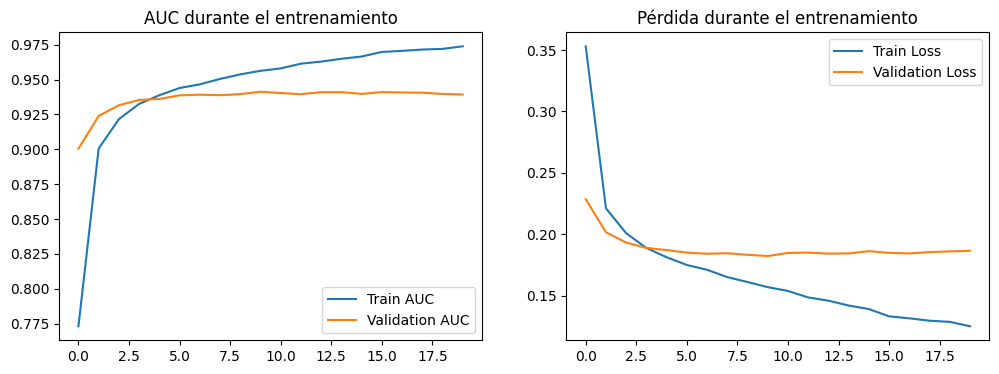

Modelo optimizado guardado como 'final_optimized_model.keras'


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from keras import backend as K

# Limpiar sesión previa
K.clear_session()

# Parámetros óptimos encontrados
BEST_PARAMS = {
    'units1': 384,
    'units2': 512,
    'learning_rate': 0.0001,
    'activation': 'relu',
    'batch_size': 16
}

# Crear modelo con la arquitectura óptima
def create_optimized_model():
    model = Sequential()
    
    # Capa de entrada y primera capa oculta con parámetros óptimos
    model.add(Dense(BEST_PARAMS['units1'], 
                   input_shape=(dims,), 
                   activation=BEST_PARAMS['activation'],
                   kernel_initializer='he_normal'))
    
    # Añadir Batch Normalization para mejorar estabilidad
    model.add(tf.keras.layers.BatchNormalization())
    
    # Segunda capa oculta con parámetros óptimos
    model.add(Dense(BEST_PARAMS['units2'], 
               activation=BEST_PARAMS['activation'],
               kernel_initializer='he_normal'))
    
    # Añadir Dropout para regularización
    model.add(tf.keras.layers.Dropout(0.3))
    
    # Capa de salida
    model.add(Dense(output_var, activation='sigmoid'))
    
    # Optimizador con learning rate óptimo
    optimizer = Adam(learning_rate=BEST_PARAMS['learning_rate'])
    
    # Compilar el modelo
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    
    return model

# Crear modelo optimizado
optimized_model = create_optimized_model()

# Callbacks adicionales para mejorar el entrenamiento
callbacks = [
    EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=5, min_lr=1e-6, mode='max'),
    tf.keras.callbacks.ModelCheckpoint('best_optimized_model.keras', 
                                     save_best_only=True,
                                     monitor='val_auc',
                                     mode='max')
]

# Entrenar el modelo optimizado
history = optimized_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,  
    batch_size=BEST_PARAMS['batch_size'],
    callbacks=callbacks,
    verbose=1
)

# Evaluar el modelo optimizado
print("\nEvaluación del modelo optimizado:")
val_loss, val_acc, val_auc = optimized_model.evaluate(X_val, y_val, verbose=0)
print(f"Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}")

# Visualizar el rendimiento
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC durante el entrenamiento')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Pérdida durante el entrenamiento')
plt.legend()
plt.show()

# Guardar el modelo final
optimized_model.save('final_optimized_model.keras')
print("Modelo optimizado guardado como 'final_optimized_model.keras'")

In [18]:
roc_auc_test = roc_auc_score(y_genres, model.predict(X), average='macro')
roc_auc_test

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step


np.float64(0.9440808075417034)

In [17]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_Optimizado.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.003826,0.010535,0.001041,0.005279,0.034728,0.009908,0.000813,0.828921,0.003736,0.063527,...,0.001083,0.274778,0.000293,0.823659,0.004687,0.003864,0.000108,0.239889,0.000364,0.007303
4,0.338223,0.019150,0.000023,0.149636,0.022034,0.294996,0.009672,0.803066,0.000690,0.000417,...,0.003175,0.018507,0.001567,0.012976,0.000092,0.000729,0.004812,0.200908,0.004179,0.000368
5,0.024317,0.002452,0.001005,0.046053,0.031771,0.889381,0.003454,0.911938,0.001972,0.021423,...,0.003444,0.624904,0.001778,0.162667,0.014017,0.001025,0.004506,0.854663,0.000997,0.002059
6,0.193369,0.364911,0.001922,0.004117,0.160503,0.069991,0.000297,0.614352,0.005254,0.008135,...,0.004989,0.034712,0.000273,0.299327,0.038115,0.000328,0.004662,0.434567,0.370731,0.002593
7,0.003295,0.004324,0.002552,0.006000,0.086115,0.059999,0.004432,0.163565,0.009997,0.061233,...,0.004538,0.169938,0.000161,0.062322,0.840569,0.004950,0.000449,0.476101,0.000383,0.000162


In [19]:
from transformers import GPT2Tokenizer, GPT2Model
import torch

# Configurar dispositivo (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar modelo y tokenizador
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2').to(device)
tokenizer.pad_token = tokenizer.eos_token  # Necesario para padding

def get_gpt2_embeddings(texts, batch_size=8):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(
            batch, 
            return_tensors="pt", 
            padding=True, 
            truncation=True, 
            max_length=512
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Usamos el promedio de los hidden states del último layer
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(batch_embeddings)
    
    return np.vstack(embeddings)

# Generar embeddings para entrenamiento y prueba
X_train_gpt2 = get_gpt2_embeddings(dataTraining['plot'].tolist())
X_test_gpt2 = get_gpt2_embeddings(dataTesting['plot'].tolist())

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [21]:
import numpy as np
import pandas as pd
import torch
import tensorflow as tf
from transformers import GPT2Tokenizer, GPT2Model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# 1. Cargar y preparar los datos (asegúrate de tener dataTraining definido)
if isinstance(dataTraining['genres'].iloc[0], str):
    dataTraining['genres'] = dataTraining['genres'].apply(eval)

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(dataTraining['genres'])

# 2. Generar embeddings con GPT-2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model_gpt2 = GPT2Model.from_pretrained('gpt2').to(device)
tokenizer.pad_token = tokenizer.eos_token

def get_gpt2_embeddings(texts, batch_size=8):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model_gpt2(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

# Generar embeddings para todos los datos primero
X_gpt2 = get_gpt2_embeddings(dataTraining['plot'].tolist())

# Dividir en entrenamiento y validación
X_train_gpt2, X_val_gpt2, y_train, y_val = train_test_split(X_gpt2, y, test_size=0.2, random_state=42)

# 3. Construir y entrenar el modelo
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_gpt2.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dense(y.shape[1], activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

history = model.fit(
    X_train_gpt2, y_train,
    validation_data=(X_val_gpt2, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# 4. Evaluar el modelo
val_loss, val_acc, val_auc = model.evaluate(X_val_gpt2, y_val)
print(f"\nResultados en validación: Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}")

# 5. Predecir en datos de prueba (si tienes dataTesting)
if 'dataTesting' in locals():
    X_test_gpt2 = get_gpt2_embeddings(dataTesting['plot'].tolist())
    y_pred_test = model.predict(X_test_gpt2)
    res = pd.DataFrame(y_pred_test, index=dataTesting.index, columns=mlb.classes_)
    res.to_csv('pred_genres_gpt2.csv', index_label='ID')
    print("\nPredicciones guardadas en 'pred_genres_gpt2.csv'")

Epoch 1/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1720 - auc: 0.6966 - loss: 0.5567 - val_accuracy: 0.2052 - val_auc: 0.8294 - val_loss: 0.2759
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2503 - auc: 0.8296 - loss: 0.2732 - val_accuracy: 0.2413 - val_auc: 0.8670 - val_loss: 0.2520
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2937 - auc: 0.8676 - loss: 0.2489 - val_accuracy: 0.2445 - val_auc: 0.8828 - val_loss: 0.2411
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3140 - auc: 0.8887 - loss: 0.2356 - val_accuracy: 0.3395 - val_auc: 0.9045 - val_loss: 0.2225
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3531 - auc: 0.8990 - loss: 0.2260 - val_accuracy: 0.2863 - val_auc: 0.9018 - val_loss: 0.2278
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3605 - auc: 0.9027 - loss: 0.2210 - val_accuracy: 0.3483 - val_auc: 0.9109 - val_loss: 0.2163
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 